Since the uprising of Artificial Intelligence, text classification has become one of the most staggering tasks to accomplish. In layman terms, We can say Artificial Intelligence is the field which tries to achieve human-like intelligent models to ease the jobs for all of us. We have an astounding proficiency in text classification but even many sophisticated NLP models are failed to achieve proficiency even close to it. So the question arises is that what we humans do differently? How do we classify text?

First of all, we understand words not each and every word but many of them and we can guess even unknown words just by the structure of a sentence. Then we understand the message that those series of words (sentence) conveys. Then from those series of sentences, we understand the meaning of a paragraph or an article. The similar approach is used in Hierarchical Attention model.

**To Learn Hierarchical Attention Network completely go [here](https://medium.com/@heetsankesara3/hierarchical-attention-networks-d220318cf87e)**

** Click [here](https://github.com/Hsankesara/DeepResearch/tree/master/Hierarchical_Attention_Network) to go to the code**


In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer,  text_to_word_sequence
from tensorflow.keras.layers import Layer, InputSpec

from tensorflow.keras import initializers as initializers, regularizers, constraints
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding, Input, Dense, LSTM, GRU, Bidirectional, TimeDistributed, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
import nltk
import re
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import roc_auc_score
from nltk import tokenize
import seaborn as sns

In [2]:
def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatibl|e with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)

In [2]:
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Layer
from tensorflow.keras import initializers, regularizers, constraints

def dot_product(x, kernel):
    """
    https://github.com/richliao/textClassifier/issues/13#issuecomment-377323318
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)
    

class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    
    Note: The layer has been tested with Keras 2.0.6
    
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """
    
    def __init__(self, return_coefficients=False,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        
        self.supports_masking = True
        self.return_coefficients = return_coefficients
        self.init = initializers.get('glorot_uniform')
        
        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)
        
        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)
        
        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)
    
    def build(self, input_shape):
        assert len(input_shape) == 3
        
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape=(input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        
        self.u = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)
        
        super(AttentionWithContext, self).build(input_shape)
    
    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None
    
    def call(self, x, mask=None):
        uit = dot_product(x, self.W)
        
        if self.bias:
            uit += self.b
        
        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)
        
        a = K.exp(ait)
        
        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())
        
        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        
        a = K.expand_dims(a)
        weighted_input = x * a
        
        if self.return_coefficients:
            return [K.sum(weighted_input, axis=1), a]
        else:
            return K.sum(weighted_input, axis=1)
    
    
    
    def compute_output_shape(self, input_shape):
        if self.return_coefficients:
            return [(input_shape[0], input_shape[-1]), (input_shape[0], input_shape[-1], 1)]
        else:
            return input_shape[0], input_shape[-1]
    def get_config(self):
        base_config = super(AttentionWithContext, self).get_config()
        #base_config['output_dim'] = self.output_dim
        return base_config

### Attention Layer

### Config

In [4]:
max_features=200000
max_senten_len=40
max_senten_num=6
embed_size=100
VALIDATION_SPLIT = 0.2

### Data

In [5]:
from sklearn.utils import shuffle

In [6]:
df = shuffle(pd.read_json('E:/saves/News_Category_Dataset_v2.json', lines=True)).reset_index()

In [7]:
len(df.category.unique())

41

In [8]:
df.head()

,index,category,headline,authors,link,short_description,date
0,84129,SPORTS,Is the Commissioner an Arbitrator?,"Roger I. Abrams, ContributorRichardson Profess...",https://www.huffingtonpost.com/entry/is-the-co...,"In the Brady case, if the parties are not able...",2015-08-01
1,3027,POLITICS,Republicans Are Seeing Weak Returns On The Tax...,Ariel Edwards-Levy and Arthur Delaney,https://www.huffingtonpost.com/entry/republica...,It was supposed to be an asset come November. ...,2018-03-30
2,188769,STYLE & BEAUTY,Shalom Harlow Flashes Boobs To Stranger For Oy...,,https://www.huffingtonpost.com/entry/shalom-ha...,CLARIFICATION: This piece has been edited to r...,2012-06-06
3,70825,MEDIA,Turkish President Erdogan Had Me Jailed For Te...,,https://www.huffingtonpost.comhttp://www.thegu...,"In Turkey, a debate as old as government itsel...",2015-12-29
4,158150,PARENTING,5 Things I Learned to Love About Competitive S...,"Leah Ariniello, Contributor\nJournalist, Colum...",https://www.huffingtonpost.com/entry/competiti...,There are a number of really good reasons to h...,2013-04-29


In [9]:
df.category.unique()

array(['SPORTS', 'POLITICS', 'STYLE & BEAUTY', 'MEDIA', 'PARENTING',
       'THE WORLDPOST', 'WELLNESS', 'DIVORCE', 'FOOD & DRINK',
       'ENTERTAINMENT', 'BLACK VOICES', 'ARTS', 'HEALTHY LIVING',
       'IMPACT', 'TRAVEL', 'WEIRD NEWS', 'QUEER VOICES', 'HOME & LIVING',
       'RELIGION', 'ENVIRONMENT', 'BUSINESS', 'WOMEN', 'MONEY', 'TECH',
       'WEDDINGS', 'PARENTS', 'EDUCATION', 'WORLDPOST', 'CRIME', 'COMEDY',
       'WORLD NEWS', 'ARTS & CULTURE', 'FIFTY', 'COLLEGE', 'GREEN',
       'SCIENCE', 'TASTE', 'LATINO VOICES', 'STYLE', 'CULTURE & ARTS',
       'GOOD NEWS'], dtype=object)

In [10]:
df.category = df.category.map(lambda x: "WORLDPOST" if x == "THE WORLDPOST" else x)

In [11]:
df['text'] = df['headline'] +'. ' +df['short_description']

In [12]:
df.head()

,index,category,headline,authors,link,short_description,date,text
0,84129,SPORTS,Is the Commissioner an Arbitrator?,"Roger I. Abrams, ContributorRichardson Profess...",https://www.huffingtonpost.com/entry/is-the-co...,"In the Brady case, if the parties are not able...",2015-08-01,Is the Commissioner an Arbitrator?. In the Bra...
1,3027,POLITICS,Republicans Are Seeing Weak Returns On The Tax...,Ariel Edwards-Levy and Arthur Delaney,https://www.huffingtonpost.com/entry/republica...,It was supposed to be an asset come November. ...,2018-03-30,Republicans Are Seeing Weak Returns On The Tax...
2,188769,STYLE & BEAUTY,Shalom Harlow Flashes Boobs To Stranger For Oy...,,https://www.huffingtonpost.com/entry/shalom-ha...,CLARIFICATION: This piece has been edited to r...,2012-06-06,Shalom Harlow Flashes Boobs To Stranger For Oy...
3,70825,MEDIA,Turkish President Erdogan Had Me Jailed For Te...,,https://www.huffingtonpost.comhttp://www.thegu...,"In Turkey, a debate as old as government itsel...",2015-12-29,Turkish President Erdogan Had Me Jailed For Te...
4,158150,PARENTING,5 Things I Learned to Love About Competitive S...,"Leah Ariniello, Contributor\nJournalist, Colum...",https://www.huffingtonpost.com/entry/competiti...,There are a number of really good reasons to h...,2013-04-29,5 Things I Learned to Love About Competitive S...


In [13]:
df['text'][0]

'Is the Commissioner an Arbitrator?. In the Brady case, if the parties are not able to settle the matter, the Federal District Court in Manhattan will have to determine whether the Commissioner\'s decision was "arbitrary and capricious," not whether it "drew its essence from the collective bargaining agreement."'

In [14]:
df = df[['text', 'category']]

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200853 entries, 0 to 200852
Data columns (total 2 columns):
text        200853 non-null object
category    200853 non-null object
dtypes: object(2)
memory usage: 3.1+ MB


In [16]:
categories = df['category']
text = df['text']

In [17]:
text

0         Is the Commissioner an Arbitrator?. In the Bra...
1         Republicans Are Seeing Weak Returns On The Tax...
2         Shalom Harlow Flashes Boobs To Stranger For Oy...
3         Turkish President Erdogan Had Me Jailed For Te...
4         5 Things I Learned to Love About Competitive S...
                                ...                        
200848    How to Change Your Beliefs and Stick to Your G...
200849    Blue Sky Soda's Cherry Vanilla Creme Is A Blas...
200850    Michael Pollan Pinpoints What's Wrong With The...
200851    Why I'm Worried: An Inhospitable Present For P...
200852    After Deadly Mass Shooting, White House Says I...
Name: text, Length: 200853, dtype: object

In [18]:
cates = df.groupby('category')
print("total categories:", cates.ngroups)
print(cates.size())

total categories: 40
category
ARTS               1509
ARTS & CULTURE     1339
BLACK VOICES       4528
BUSINESS           5937
COLLEGE            1144
COMEDY             5175
CRIME              3405
CULTURE & ARTS     1030
DIVORCE            3426
EDUCATION          1004
ENTERTAINMENT     16058
ENVIRONMENT        1323
FIFTY              1401
FOOD & DRINK       6226
GOOD NEWS          1398
GREEN              2622
HEALTHY LIVING     6694
HOME & LIVING      4195
IMPACT             3459
LATINO VOICES      1129
MEDIA              2815
MONEY              1707
PARENTING          8677
PARENTS            3955
POLITICS          32739
QUEER VOICES       6314
RELIGION           2556
SCIENCE            2178
SPORTS             4884
STYLE              2254
STYLE & BEAUTY     9649
TASTE              2096
TECH               2082
TRAVEL             9887
WEDDINGS           3651
WEIRD NEWS         2670
WELLNESS          17827
WOMEN              3490
WORLD NEWS         2177
WORLDPOST          6243
dtype: int

In [19]:
import re
def clean_str(string):
    """
    Tokenization/string cleaning for dataset
    Every dataset is lower cased except
    """
    string = re.sub(r"\\", "", string)    
    string = re.sub(r"\'", "", string)    
    string = re.sub(r"\"", "", string)    
    return string.strip().lower()

In [20]:
paras = []
labels = []
texts = []

In [21]:
df.text.shape[0]

200853

In [22]:
df2 = pd.DataFrame(columns=['text'])

In [23]:
df2

,text


In [24]:
df2 = pd.DataFrame([["welcome to florida"]], index = [["text"]])

In [25]:
df2

,0
text,welcome to florida


In [56]:
sent_lens = []
sent_nums = []
for idx in range(df.text.shape[0]):
    text = clean_str(df.text[idx])
    texts.append(text)
    sentences = tokenize.sent_tokenize(text)
    sent_nums.append(len(sentences))
    for sent in sentences:
        sent_lens.append(len(text_to_word_sequence(sent)))
    paras.append(sentences)

KeyboardInterrupt: 

In [27]:
sent_lens = []
sent_nums = []
for idx in range(1):
    text = clean_str(df.text[idx])
    print(text)
    texts.append(text)
    #print(texts)
    sentences = tokenize.sent_tokenize(text)
    print(sentences)
    sent_nums.append(len(sentences))
    for sent in sentences:
        sent_lens.append(len(text_to_word_sequence(sent)))
        print(sent)
    paras.append(sentences)
    

is the commissioner an arbitrator?. in the brady case, if the parties are not able to settle the matter, the federal district court in manhattan will have to determine whether the commissioners decision was arbitrary and capricious, not whether it drew its essence from the collective bargaining agreement.
['is the commissioner an arbitrator?.', 'in the brady case, if the parties are not able to settle the matter, the federal district court in manhattan will have to determine whether the commissioners decision was arbitrary and capricious, not whether it drew its essence from the collective bargaining agreement.']
is the commissioner an arbitrator?.
in the brady case, if the parties are not able to settle the matter, the federal district court in manhattan will have to determine whether the commissioners decision was arbitrary and capricious, not whether it drew its essence from the collective bargaining agreement.


In [ ]:
sentences

In [28]:
sent_lens

[5, 43]

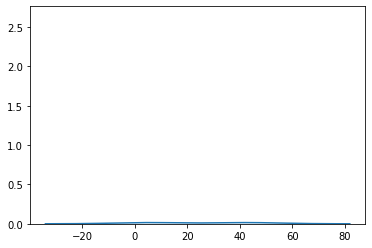

In [29]:
sns.distplot(sent_lens, bins=200)
plt.show()

C:\Users\jitesh\Anaconda3\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\jitesh\Anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


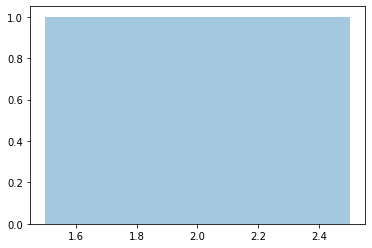

In [30]:
sns.distplot(sent_nums)
plt.show()

In [31]:
tokenizer = Tokenizer(num_words=max_features, oov_token=True)
tokenizer.fit_on_texts(texts)

In [32]:
texts

['is the commissioner an arbitrator?. in the brady case, if the parties are not able to settle the matter, the federal district court in manhattan will have to determine whether the commissioners decision was arbitrary and capricious, not whether it drew its essence from the collective bargaining agreement.',
 'republicans are seeing weak returns on the tax law. it was supposed to be an asset come november. right now, it looks like more of a wash.',
 'shalom harlow flashes boobs to stranger for oyster magazine shoot (photos). clarification: this piece has been edited to reflect that stevie dance did not characterize the girls gone wild-like shoot',
 'turkish president erdogan had me jailed for telling the truth. in turkey, a debate as old as government itself is on the agenda again. this time, it is the turkish government’s secret',
 '5 things i learned to love about competitive sports for kids. there are a number of really good reasons to have a child experience this level of competit

In [33]:
data = np.zeros((len(texts), max_senten_num, max_senten_len), dtype='int32')
for i, sentences in enumerate(paras):
    for j, sent in enumerate(sentences):
        if j< max_senten_num:
            wordTokens = text_to_word_sequence(sent)
            k=0
            for _, word in enumerate(wordTokens):
                try:
                    if k<max_senten_len and tokenizer.word_index[word]<max_features:
                        data[i,j,k] = tokenizer.word_index[word]
                        k=k+1
                except:
                    print(word)
                    pass

but if
— david
gratisography
at johansson
the hamilton creator
and its
bob mcdonnell


9052

In [34]:
p=[55,6,8,12,3,54]
p[:-3]

[55, 6, 8]

In [35]:
word_index = tokenizer.word_index
print('Total %s unique tokens.' % len(word_index))

Total 100266 unique tokens.


In [36]:
labels = pd.get_dummies(categories)

In [37]:
print('Shape of data tensor:', data.shape)
print('Shape of labels tensor:', labels.shape)

Shape of data tensor: (200854, 6, 40)
Shape of labels tensor: (200853, 40)


In [38]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
#labels = labels.iloc[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]
print('Number of positive and negative reviews in traing and validation set')
print(y_train.columns.tolist())
print(y_train.sum(axis=0).tolist())
print(y_val.sum(axis=0).tolist())

Number of positive and negative reviews in traing and validation set
['ARTS', 'ARTS & CULTURE', 'BLACK VOICES', 'BUSINESS', 'COLLEGE', 'COMEDY', 'CRIME', 'CULTURE & ARTS', 'DIVORCE', 'EDUCATION', 'ENTERTAINMENT', 'ENVIRONMENT', 'FIFTY', 'FOOD & DRINK', 'GOOD NEWS', 'GREEN', 'HEALTHY LIVING', 'HOME & LIVING', 'IMPACT', 'LATINO VOICES', 'MEDIA', 'MONEY', 'PARENTING', 'PARENTS', 'POLITICS', 'QUEER VOICES', 'RELIGION', 'SCIENCE', 'SPORTS', 'STYLE', 'STYLE & BEAUTY', 'TASTE', 'TECH', 'TRAVEL', 'WEDDINGS', 'WEIRD NEWS', 'WELLNESS', 'WOMEN', 'WORLD NEWS', 'WORLDPOST']
[1209, 1090, 3601, 4758, 916, 4174, 2727, 819, 2745, 808, 12877, 1065, 1124, 4954, 1127, 2113, 5360, 3387, 2750, 910, 2246, 1383, 6933, 3152, 26150, 5091, 2051, 1712, 3950, 1803, 7704, 1670, 1685, 7905, 2914, 2165, 14187, 2775, 1727, 4966]
[300, 249, 927, 1179, 228, 1001, 678, 211, 681, 196, 3181, 258, 277, 1272, 271, 509, 1334, 808, 709, 219, 569, 324, 1744, 803, 6589, 1223, 505, 466, 934, 451, 1945, 426, 397, 1982, 737, 505, 3

In [39]:
a=y_train.columns.tolist()
a[18]

'IMPACT'

In [40]:
word_index['hi']

9052

In [41]:
q=x_train[1]
q[1]

array([  20,   16,   64,  710,  117,  193,    5,   38,  148, 2921,    6,
        774,  382, 6284,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0])

### Model

In [42]:
REG_PARAM = 1e-13
l2_reg = regularizers.l2(REG_PARAM)

In [43]:
import os

In [44]:
GLOVE_DIR = "E:/glove/glove.6B.100d.txt"
embeddings_index = {}
f = open(GLOVE_DIR,encoding="utf8")
for line in f:
    try:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    except:
        print(word)
        pass
f.close()
print('Total %s word vectors.' % len(embeddings_index))

Total 400000 word vectors.


In [45]:
embedding_matrix = np.zeros((len(word_index) + 1, embed_size))
absent_words = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        absent_words += 1
print('Total absent words are', absent_words, 'which is', "%0.2f" % (absent_words * 100 / len(word_index)), '% of total words')

Total absent words are 27655 which is 27.58 % of total words


In [46]:
embedding_layer = Embedding(len(word_index) + 1,embed_size,weights=[embedding_matrix], input_length=max_senten_len, trainable=False)

In [47]:
word_input = Input(shape=(max_senten_len,), dtype='float32')
word_sequences = embedding_layer(word_input)
word_lstm = Bidirectional(LSTM(150, return_sequences=True, kernel_regularizer=l2_reg))(word_sequences)
word_dense = TimeDistributed(Dense(200, kernel_regularizer=l2_reg))(word_lstm)
word_att = AttentionWithContext()(word_dense)
wordEncoder = Model(word_input, word_att)

sent_input = Input(shape=(max_senten_num, max_senten_len), dtype='float32')
sent_encoder = TimeDistributed(wordEncoder)(sent_input)
sent_lstm = Bidirectional(LSTM(150, return_sequences=True, kernel_regularizer=l2_reg))(sent_encoder)
sent_dense = TimeDistributed(Dense(200, kernel_regularizer=l2_reg))(sent_lstm)
sent_att = Dropout(0.5)(AttentionWithContext()(sent_dense))
preds = Dense(40, activation='softmax')(sent_att)
model = Model(sent_input, preds)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])

In [48]:
embedding_layer

In [49]:
checkpoint = ModelCheckpoint('best_model.h5', verbose=0, monitor='val_loss',save_best_only=True, mode='auto') 

In [50]:
#x_train = np.asarray(x_train)
#y_train = np.asarray(y_train)
#x_val = np.asarray(x_val)
#y_val = np.asarray(y_val)

In [51]:
#history = model.fit(x_train, y_train ,validation_data=(x_val, y_val), epochs=10, batch_size=512, callbacks=[checkpoint])

In [52]:
#model.save('try2.h5')

## Plotting time

In [53]:
#print(history.history.keys())

In [54]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#model.save('han.h5')

In [ ]:
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Layer
from tensorflow.keras import initializers, regularizers, constraints

def dot_product(x, kernel):
    """
    https://github.com/richliao/textClassifier/issues/13#issuecomment-377323318
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)
    

class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    
    Note: The layer has been tested with Keras 2.0.6
    
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """
    
    def __init__(self, return_coefficients=False,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        
        self.supports_masking = True
        self.return_coefficients = return_coefficients
        self.init = initializers.get('glorot_uniform')
        
        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)
        
        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)
        
        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)
    
    def build(self, input_shape):
        assert len(input_shape) == 3
        
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape=(input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        
        self.u = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)
        
        super(AttentionWithContext, self).build(input_shape)
    
    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None
    
    def call(self, x, mask=None):
        uit = dot_product(x, self.W)
        
        if self.bias:
            uit += self.b
        
        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)
        
        a = K.exp(ait)
        
        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())
        
        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        
        a = K.expand_dims(a)
        weighted_input = x * a
        
        if self.return_coefficients:
            return [K.sum(weighted_input, axis=1), a]
        else:
            return K.sum(weighted_input, axis=1)
    
    
    
    def compute_output_shape(self, input_shape):
        if self.return_coefficients:
            return [(input_shape[0], input_shape[-1]), (input_shape[0], input_shape[-1], 1)]
        else:
            return input_shape[0], input_shape[-1]
    def get_config(self):
        base_config = super(AttentionWithContext, self).get_config()
        #base_config['output_dim'] = self.output_dim
        return base_config
   

In [ ]:
test="tech using climate to reduce green house gases drops by 60% and greener fields"

In [ ]:
predict_out(test)

In [ ]:
import pandas as pd
data={'text':[test]}
df3=pd.DataFrame(data)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import multi_gpu_model

In [ ]:
from tensorflow.python import keras
print(keras.__version__)

In [ ]:
y_train.to_pickle("./dummy.pkl")

In [ ]:
from tensorflow.keras.models import load_model

model3=load_model('han.h5',custom_objects={'AttentionWithContext': AttentionWithContext})

In [ ]:
#a=model3.predict(x_train[:4])

In [ ]:
#a1=a[[3]]

In [ ]:
#a

In [ ]:
#b=np.amax(a)

In [ ]:
#b

In [ ]:
#result = np.where(a==b)

In [ ]:
#print(result)

In [ ]:
#p=x_train[:1]

In [ ]:
#p[0]

In [ ]:
#y_train.columns

In [ ]:
#df3

In [ ]:
#df3=pd.read_csv('news_list.csv')

In [ ]:
#text1=df3['text']

In [ ]:
#df3['text']

In [ ]:
sent_lens = []
sent_nums = []
paras1=[]
texts=[]
for idx in range(df3.text.shape[0]):
    text = clean_str(df3.text[idx])
    texts.append(text)
    sentences = tokenize.sent_tokenize(text)
    sent_nums.append(len(sentences))
    for sent in sentences:
        sent_lens.append(len(text_to_word_sequence(sent)))
    paras1.append(sentences)

In [ ]:
sentences

In [ ]:
sent_lens

In [ ]:
data = np.zeros((len(texts), max_senten_num, max_senten_len), dtype='int32')
for i, sentences in enumerate(paras1):
    for j, sent in enumerate(sentences):
        if j< max_senten_num:
            wordTokens = text_to_word_sequence(sent)
            k=0
            for _, word in enumerate(wordTokens):
                try:
                    if k<max_senten_len and tokenizer.word_index[word]<max_features:
                        data[i,j,k] = tokenizer.word_index[word]
                        k=k+1
                except:
                    print(word)
                    pass

In [ ]:
data

In [ ]:
indices = np.arange(data.shape[0])
#np.random.shuffle(indices)
data = data[indices]
#labels = labels.iloc[indices]
#nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:2]
#y_train = labels[:-nb_validation_samples]
#x_val = data[-nb_validation_samples:]
#y_val = labels[-nb_validation_samples:]
#print('Number of positive and negative reviews in traing and validation set')
#print(y_train.columns.tolist())
#print(y_train.sum(axis=0).tolist())
#print(y_val.sum(axis=0).tolist())

In [ ]:
x_train

In [ ]:
a=model3.predict(x_train[:2])
a

In [ ]:
b=np.amax(a)

In [ ]:
b

In [ ]:
result = np.where(a==b)


In [ ]:
pos=result[1].item(0)

In [ ]:
pos

In [ ]:
a=y_train.columns.tolist()
a[pos]

In [ ]:
y_train

In [3]:
from tensorflow.keras.models import load_model

model3=load_model('han.h5',custom_objects={'AttentionWithContext': AttentionWithContext})

In [4]:
max_features=200000
max_senten_len=40
max_senten_num=6
embed_size=100
VALIDATION_SPLIT = 0.2
import re
def clean_str(string):
    """
    Tokenization/string cleaning for dataset
    Every dataset is lower cased except
    """
    string = re.sub(r"\\", "", string)    
    string = re.sub(r"\'", "", string)    
    string = re.sub(r"\"", "", string)    
    return string.strip().lower()

def predict_out(test):


    data={'text':[test]}
    df3=pd.DataFrame(data)
    sent_lens = []
    sent_nums = []
    paras1=[]
    texts=[]
    for idx in range(df3.text.shape[0]):
        text = clean_str(df3.text[idx])
        texts.append(text)
        sentences = tokenize.sent_tokenize(text)
        sent_nums.append(len(sentences))
        for sent in sentences:
            sent_lens.append(len(text_to_word_sequence(sent)))
        paras1.append(sentences)
        data = np.zeros((len(texts), max_senten_num, max_senten_len), dtype='int32')
    for i, sentences in enumerate(paras1):
        for j, sent in enumerate(sentences):
            if j< max_senten_num:
                wordTokens = text_to_word_sequence(sent)
                k=0
                for _, word in enumerate(wordTokens):
                    try:
                        if k<max_senten_len and tokenizer.word_index[word]<max_features:
                            data[i,j,k] = tokenizer.word_index[word]
                            k=k+1
                    except:
                        #print(word)
                        pass
    indices = np.arange(data.shape[0])
#np.random.shuffle(indices)
    data = data[indices]
#labels = labels.iloc[indices]
#nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

    x_train = data[:2]
    a=model3.predict(x_train[:2])
    print(a)
    b=np.amax(a)
    print(b)
    result = np.where(a==b)
    pos=result[1].item(0)
    print(pos)
    
    a=y_train.columns.tolist()
    return a[pos]

In [5]:
import pickle

# saving
#with open('tokenizer.pickle', 'wb') as handle:
    #pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
y_train = pd.read_pickle("./dummy.pkl")
y_train
# loading
with open('tokenizer.pickle', 'rb') as handle:
      tokenizer = pickle.load(handle)
        

In [6]:
from flask import Flask, redirect, url_for, render_template, request, session,jsonify

In [7]:
from werkzeug.wrappers import Request, Response

In [ ]:
app = Flask(__name__, template_folder='./')
app.static_folder = 'static'

@app.route('/prediction', methods=['POST', 'GET'])
def prediction():
    if request.method == "POST":
        message = request.form['message']
        print(message)
        response =  predict_out(message)
        print(response)
        msg="The news category is"
        return jsonify(msg,response)
    
    return jsonify("Input text")

@app.route('/')
def main():
    return render_template('index.html')


if __name__ == '__main__':
    #app.run(debug=True)
    from werkzeug.serving import run_simple
    run_simple('localhost', 9000, app)
    
@app.route('/shutdown', methods=['POST'])
def shutdown():
    shutdown_server()
    return 'Server shutting down...'

    

 * Running on http://localhost:9000/ (Press CTRL+C to quit)
127.0.0.1 - - [30/Apr/2020 13:32:54] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [30/Apr/2020 13:32:54] "GET /staticnews.jpeg HTTP/1.1" 404 -
127.0.0.1 - - [30/Apr/2020 13:32:54] "GET /favicon.ico HTTP/1.1" 404 -


Amitabh Bachchan 'Hosts' KBC on Instagram, Asks Fans to Guess His Popular Bollywood Movie


127.0.0.1 - - [30/Apr/2020 13:33:07] "POST /prediction HTTP/1.1" 200 -


[[1.8984654e-09 1.3893258e-09 4.8709251e-07 2.6623871e-08 2.0455192e-13
  1.8710585e-05 1.0948923e-12 2.0525010e-15 3.7649291e-16 6.3732927e-14
  9.9995434e-01 9.2964844e-17 2.7268661e-11 2.2767600e-16 4.1910958e-08
  1.9320656e-09 7.7769961e-08 4.4644003e-13 1.3338736e-09 2.9886739e-11
  1.0758986e-06 2.3451621e-18 3.4543928e-12 2.4693029e-05 2.1622081e-07
  2.6847084e-07 1.9361058e-12 1.6066102e-12 4.1490011e-10 5.0159867e-09
  5.7079259e-15 9.8882690e-12 2.8894822e-11 5.8148547e-12 7.4984237e-18
  1.9744193e-09 3.0298860e-14 1.3663002e-07 9.2259019e-16 3.8922768e-10]]
0.99995434
10
ENTERTAINMENT
Rishi Kapoor, Legendary Bollywood Actor, Dies at 67


127.0.0.1 - - [30/Apr/2020 13:33:39] "POST /prediction HTTP/1.1" 200 -


[[3.9373691e-07 2.0060206e-08 2.6040148e-06 6.6107496e-06 1.7925421e-06
  1.5745107e-06 3.2710773e-07 5.0866769e-11 9.2032444e-08 4.0493674e-08
  2.0042689e-06 1.6481028e-13 4.0192373e-07 3.1189165e-10 1.5365168e-06
  9.8437181e-07 9.9858725e-01 2.5700814e-10 5.5373977e-07 4.1147499e-09
  1.9777372e-05 8.8360144e-12 9.5961763e-09 3.1116972e-06 1.0136317e-04
  2.7356289e-06 5.2996114e-04 5.9184021e-07 8.7509989e-08 7.1563747e-08
  3.8819692e-10 1.0395631e-06 2.5396716e-08 1.1738764e-09 1.9981987e-09
  2.5058083e-07 5.6015705e-07 7.3212472e-04 1.1188332e-09 2.2220256e-06]]
0.99858725
16
HEALTHY LIVING


127.0.0.1 - - [30/Apr/2020 13:34:33] "POST /prediction HTTP/1.1" 200 -


Angelina Jolie Sends Condolences To Irrfan Khan's Family
[[1.06541496e-08 1.75621366e-08 9.95692881e-06 4.20791828e-08
  4.07080663e-12 4.50166524e-04 5.03379449e-10 1.24881225e-12
  1.11614169e-10 8.23778762e-13 9.99403715e-01 1.74688094e-14
  1.63904179e-09 1.02307135e-10 9.08345754e-09 1.30595312e-09
  9.18182423e-07 1.82792705e-11 6.18392948e-10 1.32734721e-08
  1.69119880e-06 2.43898288e-15 3.32404082e-09 9.16975769e-05
  1.52878908e-06 3.04281566e-05 6.43426923e-10 2.37736186e-09
  3.63721966e-07 6.70143845e-06 8.15820034e-09 7.11108612e-08
  9.29610380e-08 5.97746563e-08 8.07856278e-13 2.03689410e-06
  2.44823970e-11 4.46134720e-07 4.52613684e-12 1.95946708e-08]]
0.9994037
10
ENTERTAINMENT


127.0.0.1 - - [30/Apr/2020 13:35:22] "POST /prediction HTTP/1.1" 200 -


brad pitt to marry jennifer aniston
[[1.7787603e-03 2.2704920e-09 2.1278597e-08 2.3553669e-02 8.8228389e-06
  9.2228359e-01 9.0315355e-09 1.2246273e-05 6.2580469e-10 4.2008438e-07
  2.2797267e-05 2.7252836e-04 8.9337258e-04 3.1259642e-05 5.5554810e-06
  6.9986697e-04 1.3672432e-05 8.9358937e-06 4.6834107e-06 4.2215179e-11
  1.3205235e-07 1.4069957e-06 3.4404398e-05 3.3184332e-08 1.7338389e-08
  1.2142074e-05 1.2568761e-08 3.5890334e-06 9.9215853e-09 7.2080926e-05
  6.8089219e-05 2.7041731e-06 1.2807092e-06 5.0026733e-02 3.5294265e-06
  1.4458357e-05 1.6814997e-04 1.0661548e-06 8.3775624e-14 2.1956428e-09]]
0.9222836
5
COMEDY
Climate change: World mustn't forget 'deeper emergency'
[[1.04896014e-06 1.99312731e-14 4.46484094e-09 2.10213693e-06
  9.38631928e-08 1.17608157e-09 1.88508942e-08 5.79330250e-10
  8.51978095e-15 1.21976327e-05 2.68743187e-11 1.26268797e-05
  8.94946062e-10 1.49839874e-12 1.98973771e-06 9.94566917e-01
  2.56559340e-11 1.30049013e-10 5.19716414e-03 8.61211380e-10
 

127.0.0.1 - - [30/Apr/2020 13:36:30] "POST /prediction HTTP/1.1" 200 -



0.9945669
15
GREEN


In [ ]:
word_index=tokenizer.word_index

In [ ]:
word_index['bella']

In [ ]:
a